<a href="https://colab.research.google.com/github/Yuuu553/-/blob/main/%E8%A4%87%E8%B3%BD%E4%B9%9D%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

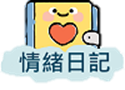

In [1]:
# 安裝相關模組
!pip install opencc-python-reimplemented
!pip install firebase-admin
!pip install gradio
!pip install gspread
!pip install oauth2client
!pip install SpeechRecognition
!pip install pytz
!pip install bcrypt snownlp
!apt-get install ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.2 MB/s eta 0:00:

In [3]:
# 匯入相關模組
import gradio as gr
import bcrypt
import json
import os
import datetime
import pytz
import random
from snownlp import SnowNLP
from google.colab import drive
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import speech_recognition as sr  # 載入語音辨識套件
import opencc
converter = opencc.OpenCC('s2t')  # s2t 代表簡體轉繁體
import firebase_admin
from firebase_admin import credentials, firestore
import random
import speech_recognition as sr
import subprocess


# 掛載 Google Drive
drive.mount('/content/drive', force_remount=True)

# Google Sheets 設置
SCOPE = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
CREDS_FILE = "/content/drive/MyDrive/Colab Notebooks/metal-node-452506-c4-6df5ac62a6e9.json"
SPREADSHEET_NAME = "EmotionDiary"

creds = ServiceAccountCredentials.from_json_keyfile_name(CREDS_FILE, SCOPE)
client = gspread.authorize(creds)

# 開啟 Google 試算表並獲取工作表
sheet = client.open_by_key('1AT-e76Sqi1RsjOftc--kjN5jZXi3tDT6cghwdlUbM9U')

#資料庫
cred = credentials.Certificate("/content/drive/MyDrive/Colab Notebooks/emotiondiary-7397c-firebase-adminsdk-fbsvc-883c6ca4bf.json")
if not firebase_admin._apps:
    firebase_admin.initialize_app(cred)


# 取得 Firestore 客戶端
db = firestore.client()

#定義
def get_random_advice(sentiment_score):
    # 依據 sentiment_score 決定要查詢的類別
    if sentiment_score > 0.6:
        category = "positive"
    elif sentiment_score > 0.4:
        category = "neutral"
    elif sentiment_score > 0.2:
        category = "negative"
    else:
        category = "very_negative"

    # 從 Firestore 讀取建議
    doc_ref = db.collection("advice").document(category)
    doc = doc_ref.get()

    if doc.exists:
        advice_list = doc.to_dict().get("texts", [])
        if advice_list:
            return random.choice(advice_list)  # 隨機選取一條建議
        else:
            return "暫時沒有建議，請稍後再試！"
    else:
        return "無法取得建議，請稍後再試！"

# 檢查是否有 "Users" 和 "Records" 工作表，若沒有則創建
try:
    users_sheet = sheet.worksheet("Users")  # 用來儲存使用者資料
except gspread.exceptions.WorksheetNotFound:
    users_sheet = sheet.add_worksheet(title="Users", rows="100", cols="2")
    users_sheet.append_row(["Username", "Password Hash"])  # 欄位名稱

try:
    records_sheet = sheet.worksheet("Records")  # 用來儲存情緒記錄
except gspread.exceptions.WorksheetNotFound:
    records_sheet = sheet.add_worksheet(title="Records", rows="100", cols="6")
    records_sheet.append_row(["Username", "Timestamp", "Emotion", "Note", "Sentiment", "Advice"])  # 欄位名稱

# 初始化資料（如果工作表是空的）
def initialize_sheets():
    # 如果 "Users" 工作表是空的，初始化表格
    if not users_sheet.get_all_values():
        users_sheet.append_row(["Username", "Password Hash"])  # 欄位名稱

    # 如果 "Records" 工作表是空的，初始化表格
    if not records_sheet.get_all_values():
        records_sheet.append_row(["Username", "Timestamp", "Emotion", "Note", "Sentiment", "Advice"])  # 欄位名稱

initialize_sheets()


# 全域變數
session_user = None

# 註冊新使用者
def register_user(username, password):
    # 確保帳號和密碼都不能為空
    if not username or not password:
        return "帳號和密碼不能為空！"

    # 檢查帳號是否已經註冊
    users_data = users_sheet.get_all_values()
    if any(user[0] == username for user in users_data[1:]):  # 排除表頭
        return "使用者名稱已存在！"

    # 雜湊密碼並註冊新帳號
    hashed_password = bcrypt.hashpw(password.encode(), bcrypt.gensalt()).decode()
    users_sheet.append_row([username, hashed_password])
    return "註冊成功！"

# 登入
def login_user(username, password):
    global session_user
    # 檢查帳號是否存在
    users_data = users_sheet.get_all_values()
    user = next((u for u in users_data[1:] if u[0] == username), None)  # 排除表頭

    if username == "" or password == "":
        return "帳號或密碼不能為空！", gr.update(visible=False), gr.update(visible=True)

    if user and bcrypt.checkpw(password.encode(), user[1].encode()):
        session_user = username
        return f"歡迎，{username}！", gr.update(visible=True), gr.update(visible=False)

    session_user = None
    return "登入失敗，請檢查使用者名稱與密碼！", gr.update(visible=False), gr.update(visible=True)

# 儲存情緒記錄到 Google Sheets
def save_entry(username, mood):
    if not username:
        return "請先登入！", []

    timestamp = get_current_time_in_timezone("Asia/Taipei")

    # 進行情緒分析
    sentiment_score = SnowNLP(mood).sentiments
    advice = get_random_advice(sentiment_score)

    # 儲存到 Google Sheets，移除 note 欄位
    records_sheet.append_row([username, timestamp, mood, round(sentiment_score, 2), advice])

    # 更新顯示紀錄
    # 依據 sentiment_score 顯示不同心情符號
    if sentiment_score > 0.6:   # "positive"
        mood_symbols = "😁"
    elif sentiment_score > 0.4: # "neutral"
        mood_symbols = "🙂"
    elif sentiment_score > 0.2: # "negative"
        mood_symbols = "😑"
    else:                       # "very_negative"
        mood_symbols = "😥"
    return f"紀錄已儲存！ 情緒得分:{mood_symbols}  {round(sentiment_score, 2)}，建議: {advice}", get_user_records()[1]

# 設定時區
def get_current_time_in_timezone(timezone="Asia/Taipei"):
    tz = pytz.timezone(timezone)
    return datetime.datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")

# 根據情緒得分提供建議
def get_random_advice(sentiment_score):
    # 依據 sentiment_score 決定要查詢的類別
    if sentiment_score > 0.6:
        category = "positive"
    elif sentiment_score > 0.4:
        category = "neutral"
    elif sentiment_score > 0.2:
        category = "negative"
    else:
        category = "very_negative"

    # 從 Firestore 讀取建議
    doc_ref = db.collection("advice").document(category)
    doc = doc_ref.get()

    if doc.exists:
        advice_list = doc.to_dict().get("texts", [])
        if advice_list:
            return random.choice(advice_list)  # 隨機選取一條建議
        else:
            return "暫時沒有建議，請稍後再試！"
    else:
        return "無法取得建議，請稍後再試！"


# 將音訊轉換為 WAV 格式（確保 SpeechRecognition 可讀取）
def convert_audio_to_wav(input_path, output_path):
    try:
        subprocess.run(["ffmpeg", "-i", input_path, output_path], check=True)
    except Exception as e:
        print(f"音檔轉換錯誤: {e}")

#語音轉文字字體為繁體
def audio_to_text(audio_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_google(audio_data, language="zh-TW")  # 設定為繁體中文
            return converter.convert(text)  # 轉換為繁體
        except sr.UnknownValueError:
            return "無法辨識語音，請再試一次！"
        except sr.RequestError:
            return "語音辨識服務不可用，請稍後再試！"

# 儲存情緒紀錄（文字轉語音）
def save_record_from_audio(audio):
    global session_user
    if not session_user:
        return "請先登入！", "", []

    if not audio or not os.path.exists(audio):
        return "未偵測到音訊，請先錄音再提交！", "", []

    # 確保音檔為 WAV 格式
    wav_path = f"{audio}.wav"
    convert_audio_to_wav(audio, wav_path)

    # 呼叫語音轉換函數
    text = audio_to_text(wav_path)

    if not text.strip():
        return "請填寫感受！", "", []

    # 進行情緒分析
    sentiment_score = SnowNLP(text).sentiments
    advice = get_random_advice(sentiment_score)

    # 儲存紀錄
    timestamp = get_current_time_in_timezone("Asia/Taipei")
    records_sheet.append_row([session_user, timestamp, text, round(sentiment_score, 2), advice])

    _, indexed_records = get_user_records()
    return f"記錄已儲存！ 情緒得分: {round(sentiment_score, 2)}，建議: {advice}", text, indexed_records



# 獲取當前使用者的紀錄
def get_user_records():
    if not session_user:
        return "請先登入！", []

    user_records = records_sheet.get_all_values()
    user_records = [r for r in user_records[1:] if r[0] == session_user]

    indexed_records = [
        [idx + 1, record[2], record[3], record[4], record[1]]  # 移除 note 欄位
        for idx, record in enumerate(user_records)
    ]

    return "以下是你的紀錄：", indexed_records

# 刪除指定紀錄
def delete_record(index):
    if not session_user:
        return "請先登入！", []

    user_records = records_sheet.get_all_values()
    user_records = [r for r in user_records[1:] if r[0] == session_user]  # 只取出當前使用者的紀錄

    if 1 <= index <= len(user_records):  # 檢查索引是否有效
        record_to_delete = user_records[index - 1]  # 確保取出的紀錄是正確的
        record_id = record_to_delete[1]  # 使用紀錄的時間戳作為識別
        row_to_delete = None

        # 找到該紀錄在原表格中的位置
        for i, row in enumerate(records_sheet.get_all_values()):
            if row[1] == record_id:
                row_to_delete = i + 1  # 1基索引
                break

        if row_to_delete:
            records_sheet.delete_rows(row_to_delete)  # 刪除該行
            # 直接刷新資料框架
            user_records = records_sheet.get_all_values()
            user_records = [r for r in user_records[1:] if r[0] == session_user]

            indexed_records = [
    [idx + 1, record[2], record[3], record[4], record[1]]  # 保持與 `history_display` 相同的 5 欄
    for idx, record in enumerate(user_records)
]


            return f"已刪除記錄：{record_to_delete[2]} - {record_to_delete[3]}", gr.update(value=indexed_records)
        else:
            updated_message, updated_records = get_user_records()
            return "刪除失敗，未找到該紀錄。", gr.update(value=updated_message), gr.update(value=updated_records)

    updated_message, updated_records = get_user_records()
    return "刪除失敗，請檢查索引是否正確。", gr.update(value=updated_message), gr.update(value=updated_records)

# 清除所有記錄
def clear_records():
    if not session_user:
        return "請先登入！", []

    user_records = records_sheet.get_all_values()
    rows_to_delete = [i + 1 for i, row in enumerate(user_records) if row[0] == session_user]

    # 從後往前刪除，避免刪除錯誤的行
    for row in reversed(rows_to_delete):
        records_sheet.delete_rows(row)

    return "所有記錄已清除！", []


# 登出
def logout_user():
    global session_user
    session_user = None
    return "您已登出！", gr.update(visible=False), gr.update(visible=True), []


with gr.Blocks() as app:
    # 分頁分組
    with gr.Row():
        login_form = gr.Group(visible=True)  # 登入與註冊表單
        dashboard = gr.Group(visible=False)  # 使用者登入後的儀表板

    # 登入與註冊表單
    with login_form:
          gr.Markdown("# 🎭 情緒日記")
          gr.Markdown("**記錄你的心情，探索內心世界 💙**")

          message_label = gr.Label(label="訊息")
          username_input = gr.Textbox(label="使用者名稱")
          password_input = gr.Textbox(label="密碼", type="password")
          with gr.Row():
              login_button = gr.Button("登入")
              register_button = gr.Button("註冊")

    # 儀表板功能
    with dashboard:
        gr.Markdown("# 情緒紀錄日記📓")
        shared_message_label = gr.Label(label="訊息")  # 共用訊息欄

        # 頁面切換按鈕
        with gr.Row():
            record_page_button = gr.Button("寫情緒紀錄✍️")
            history_page_button = gr.Button("查看與刪除紀錄👀")
            help_page_button = gr.Button("協助管道🆘")  # 新增的按鈕

        # 情緒紀錄頁面
        with gr.Group(visible=True) as record_page:
            gr.Markdown("### 寫情緒紀錄")
            with gr.Row():
                note_input = gr.Textbox(label="寫下你的感受...", lines=6, placeholder="請輸入文字", show_label=True)
            with gr.Row():
                save_button = gr.Button("儲存記錄")
            with gr.Group():
                gr.Markdown("### 語音輸入")
                audio_input = gr.Audio(label="請錄音 (錄音完成後會自動轉換)", type="filepath", interactive=True)  # 提示用戶
                text_output = gr.Textbox(label="轉換結果")  # 這行是新增的，顯示語音轉換結果

        # 查看與刪除紀錄頁面
        with gr.Group(visible=False) as history_delete_page:
            gr.Markdown("### 查看與刪除紀錄")
            history_display = gr.Dataframe(
                headers=["索引", "感受", "情緒得分", "建議", "時間"],  # 移除 note 欄位
                interactive=False
            )
            with gr.Row():
                delete_index_input = gr.Number(
                    label="輸入要刪除的記錄索引",
                    precision=0,
                    interactive=True
                )
            with gr.Row():
                delete_button = gr.Button("刪除選定記錄")
                refresh_button = gr.Button("刷新記錄")
            with gr.Row():
                clear_button = gr.Button("清除所有記錄")

        # 協助管道頁面 (新增頁面)
        with gr.Group(visible=False) as help_page:
            gr.Markdown("""
            ### 這裡列出了一些可用的協助管道，幫助你在情緒困擾時找到合適的資源與支持💗。

            🔹 **心理諮詢服務**
               提供專業的心理輔導與諮詢，幫助處理情緒困擾。可以尋求面對面的心理師諮詢。

            🔹 **放鬆技巧**
               深呼吸、冥想、瑜伽等簡單的放鬆方法，有助於舒緩壓力與焦慮。

            📞 **安心專線**
               1925(依舊愛我) 24小時提供免費心理諮詢服務。

            📞 **法鼓山人文社會基金會**
               關懷生命專線(02)2311-8585(幫我幫我)，提供電話協談服務。

            📞 **生命線**
               撥打1995提供適當的心理支持

            📞 **張老師基金會**
               撥打1980協助處理情緒及各項生活適應上的困擾。

            💬 **各縣市衛生局皆有提供免費心理諮商服務**
               縣市參考 https://www.farhugs.com/posts/67160648ef76e70001d62a8a




            """)

        # 登出按鈕
        logout_button = gr.Button("登出")

    # 事件處理綁定
    login_button.click(
        login_user,
        inputs=[username_input, password_input],
        outputs=[message_label, dashboard, login_form]
    )
    register_button.click(
        register_user,
        inputs=[username_input, password_input],
        outputs=message_label
    )
    save_button.click(
    lambda note: save_entry(session_user, note) if session_user else ("請先登入！", []),
    inputs=[note_input],
    outputs=[shared_message_label, history_display]
)

    audio_input.change(
    fn=save_record_from_audio,
    inputs=audio_input,
    outputs=[shared_message_label, text_output, history_display]
)

    delete_button.click(
        delete_record,
        inputs=delete_index_input,
        outputs=[shared_message_label, history_display]
    )
    clear_button.click(
        clear_records,
        outputs=[shared_message_label, history_display]
    )
    refresh_button.click(
        get_user_records,
        outputs=[shared_message_label, history_display]
    )


    logout_button.click(
        logout_user,
        outputs=[message_label, dashboard, login_form, history_display]
    )

    # 頁面切換功能
    record_page_button.click(
        lambda: (gr.update(visible=True), gr.update(visible=False), gr.update(visible=False)),
        outputs=[record_page, history_delete_page, help_page]
    )
    history_page_button.click(
        lambda: (gr.update(visible=False), gr.update(visible=True), gr.update(visible=False)),
        outputs=[record_page, history_delete_page, help_page]
    )
    help_page_button.click(
        lambda: (gr.update(visible=False), gr.update(visible=False), gr.update(visible=True)),
        outputs=[record_page, history_delete_page, help_page]
    )

# 啟動應用程式
app.launch()


Mounted at /content/drive
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4e4fa525aedc8469ce.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
